In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

tf.__version__

'2.9.2'

In [3]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

1668792/1668792 [==============================] - 0s 0us/step


In [4]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [6]:
dataframe['target'] = np.where(dataframe['AdoptionSpeed'] == 4, 0, 1)

dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [8]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [9]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [11]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/var/folders/yh/yw23prz55635x1mx37sy_kp40000gn/T/ipykernel_13189/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [12]:
[(train_features, label_batch)] = train_ds.take(1)

print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor(
[[ 3]
 [ 1]
 [36]
 [84]
 [ 4]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([0 1 0 0 1], shape=(5,), dtype=int64)


In [13]:
def get_normalization_layer(name, dataset):
  normalizer = layers.Normalization(axis=None)
  
  feature_ds = dataset.map(lambda x, y: x[name])
  
  normalizer.adapt(feature_ds)
  
  return normalizer

In [14]:
photo_count_col = train_features['PhotoAmt']

layer = get_normalization_layer('PhotoAmt', train_ds)

layer(photo_count_col)

2022-07-14 21:31:54.712377: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.13185515],
       [-0.83596677],
       [ 6.261394  ],
       [-0.83596677],
       [-0.83596677]], dtype=float32)>

In [19]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
    
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)
  
  feature_ds = dataset.map(lambda x, y: x[name])

  index.adapt(feature_ds)

  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  return lambda feature: encoder(index(feature))

In [20]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [21]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [22]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


/var/folders/yh/yw23prz55635x1mx37sy_kp40000gn/T/ipykernel_13189/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/var/folders/yh/yw23prz55635x1mx37sy_kp40000gn/T/ipykernel_13189/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
/var/folders/yh/yw23prz55635x1mx37sy_kp40000gn/T/ipykernel_13189/3479182957.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()

In [23]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [25]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [26]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [28]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

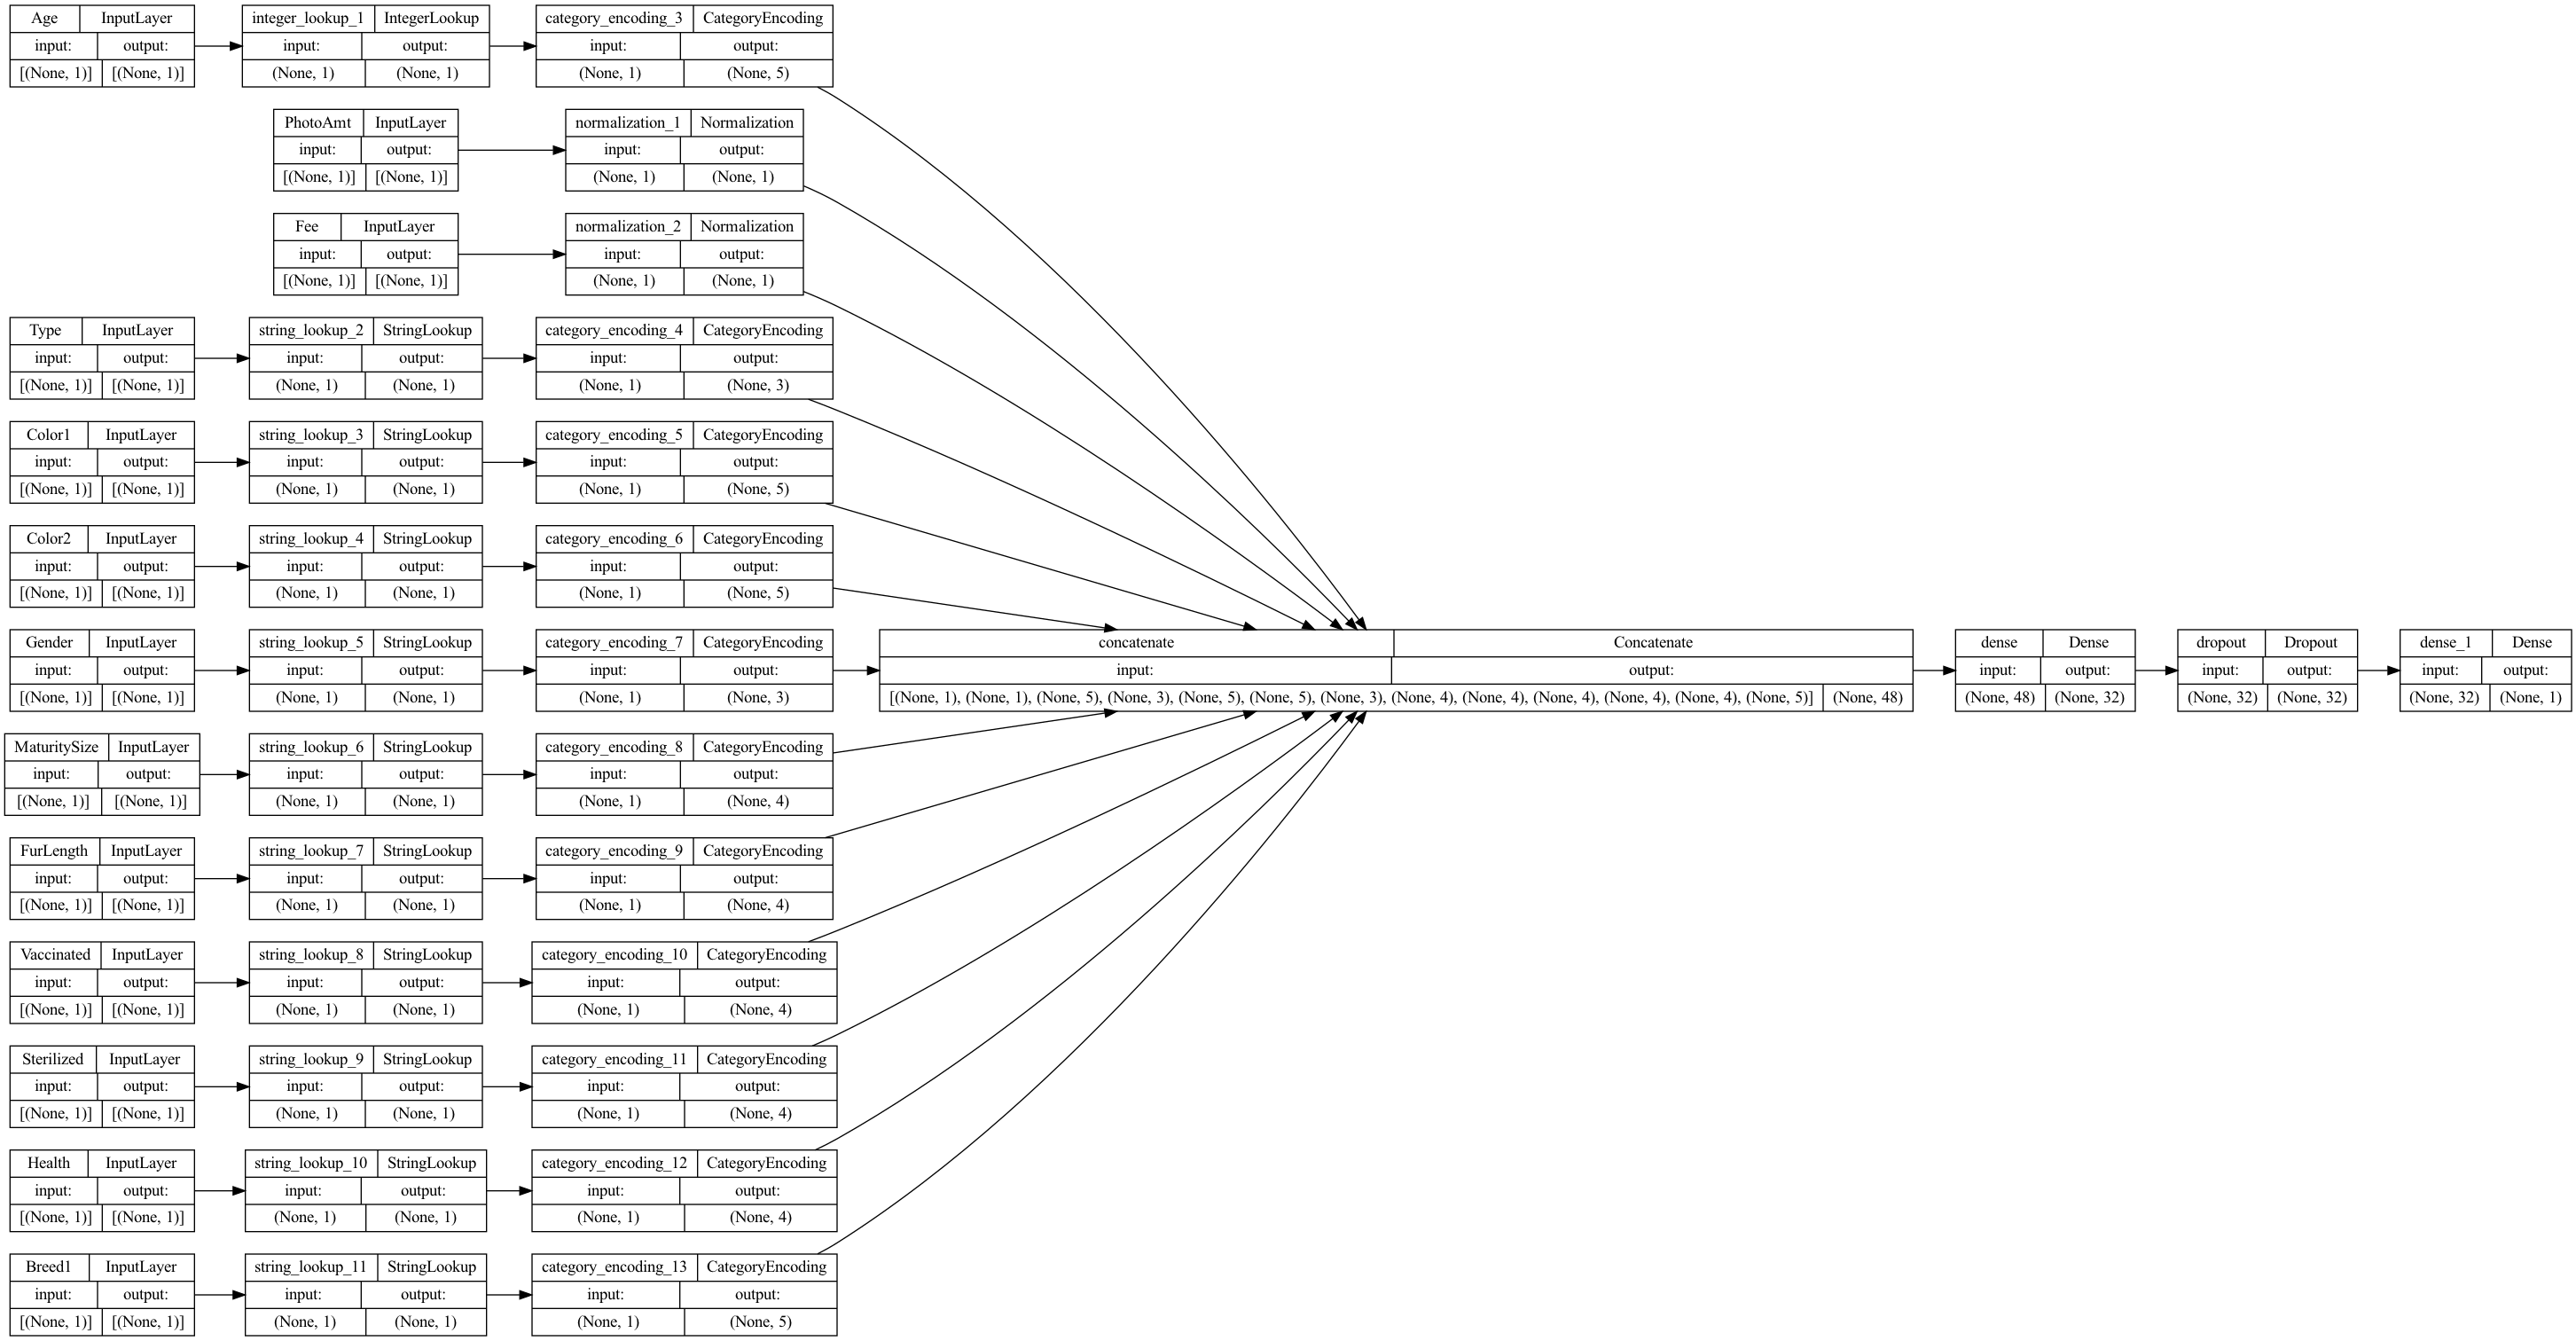

In [30]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [31]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/Users/bcp/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


37/37 [==============================] - 1s 6ms/step - loss: 0.8087 - accuracy: 0.4028 - val_loss: 0.6462 - val_accuracy: 0.5598
Epoch 2/10
37/37 [==============================] - 0s 1ms/step - loss: 0.6480 - accuracy: 0.5887 - val_loss: 0.5967 - val_accuracy: 0.6958
Epoch 3/10
37/37 [==============================] - 0s 1ms/step - loss: 0.6127 - accuracy: 0.6374 - val_loss: 0.5657 - val_accuracy: 0.7253
Epoch 4/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5792 - accuracy: 0.6597 - val_loss: 0.5463 - val_accuracy: 0.7444
Epoch 5/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5633 - accuracy: 0.6827 - val_loss: 0.5343 - val_accuracy: 0.7461
Epoch 6/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5466 - accuracy: 0.6977 - val_loss: 0.5274 - val_accuracy: 0.7522
Epoch 7/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5425 - accuracy: 0.7047 - val_loss: 0.5228 - val_accuracy: 0.7487
Epoch 8/10
37/37 [=============

In [32]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 1ms/step - loss: 0.4984 - accuracy: 0.7643
Accuracy 0.7642980813980103


In [33]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

INFO:tensorflow:Assets written to: my_pet_classifier/assets


INFO:tensorflow:Assets written to: my_pet_classifier/assets


In [34]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - 0s 187ms/step
This particular pet had a 74.6 percent probability of getting adopted.
